## Sentiment Analysis with TextBlod / VADER

### Import packages and define functions

In [41]:
# basics
from pathlib import Path
import pandas as pd
import numpy as np
import math
# plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# sentimental analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
from sklearn.metrics import accuracy_score
# warnings
import warnings; warnings.filterwarnings('ignore')

In [5]:
# a function to check sentiment score
def sentiment_analyzer_scores(sentence):
    score = sia.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [6]:
# transform text to TextBlod object
def text_sentiment(df):
    # a empty list to store sentiment scores
    X = []
    # loop through to get scores
    for i in df['Text']:
        X.append(TextBlob(i).sentiment.polarity)
    df['TextBlob'] = X
    return df

In [7]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.lower().split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [8]:
# a function to calculate the compound sentiment score
def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score/math.sqrt((score*score) + alpha)
    return norm_score

In [9]:
#Run the Roberta Model
def polarity_scores_roberta_(x):
    # process text
    x = preprocess(x)
    # 'pt' means tensor of Pytorch
    encoded_text=tokenizer(x, return_tensors='pt')
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={
        'roberta_neg':scores[0],
        'roberta_neu':scores[1],
        'roberta_pos':scores[2],
    }
    sum_s = scores[0] + scores[1] + scores[2]
    compound = normalize(sum_s)
    return compound

### Load data & inspect

In [10]:
# define Path
p = Path(r'C:\Users\user\Documents\Data\[Kaggle] Amazon Food Review\Reviews.csv')
# load data
review = pd.read_csv(p)

In [11]:
review.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [12]:
r, c = review.shape
print(f'This dataset has {c} columns and {r} rows')

This dataset has 10 columns and 568454 rows


In [13]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


That's great we don't see any missing values

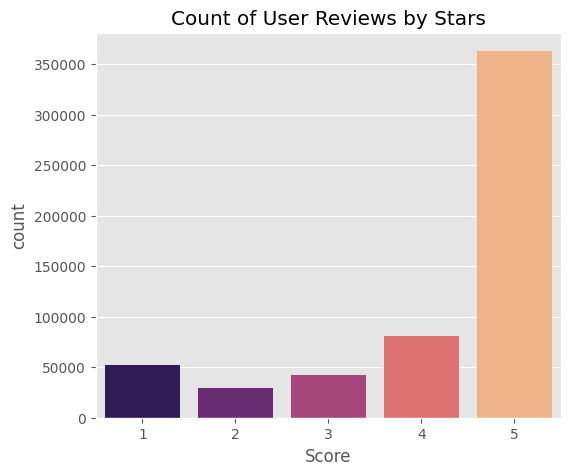

In [14]:
# see the score distribution
plt.figure(figsize=[6,5])
sns.countplot(x=review['Score'], palette="magma")
plt.title('Count of User Reviews by Stars')
plt.show()

### Process Data

In [15]:
# take columns we need only
df = review[['Text', 'Score']]

In [16]:
# drop duplicates
df.duplicated().sum() #174779
df = df.drop_duplicates(keep='first')
# show shape
print('Shape of data after dropping duplicates: ', df.shape)

Shape of data after dropping duplicates:  (393675, 2)


In [17]:
# remove neutral comments
df = df[df['Score']!= 3]
# create labels for positive and negtive attitude
df['Positive'] = np.where(df['Score'] > 3, 1, 0)
# show df
df.Positive.value_counts() / len(df)

1    0.843134
0    0.156866
Name: Positive, dtype: float64

In [18]:
df = df[['Text', 'Positive']]
df.head()

,Text,Positive
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [19]:
# show shape
print('Shape of data after dropping duplicates: ', df.shape)

Shape of data after dropping duplicates:  (363903, 2)


### VADER

VADER performs very well with emojis, slangs, and acronyms in sentences.

In [20]:
# define the vader object
sia = SentimentIntensityAnalyzer()
# try it (with a pre-defined function)
sentiment_analyzer_scores('I think today is a good day to learn NLP')
sentiment_analyzer_scores('I hate this world')

I think today is a good day to learn NLP {'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'compound': 0.4404}
I hate this world----------------------- {'neg': 0.552, 'neu': 0.448, 'pos': 0.0, 'compound': -0.5719}


In [21]:
# get VADER sentiment scores for every text
df['VADER'] = df['Text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [22]:
df.head()

,Text,Positive,VADER
0,I have bought several of the Vitality canned d...,1,0.9441
1,Product arrived labeled as Jumbo Salted Peanut...,0,-0.5664
2,This is a confection that has been around a fe...,1,0.8138
3,If you are looking for the secret ingredient i...,0,0.4404
4,Great taffy at a great price. There was a wid...,1,0.9468


### TextBlod

In [23]:
# use a pre-defined function to get sentiment scores
df = text_sentiment(df)

In [24]:
# modify the format
df['TextBlob'] = df['TextBlob'].round(4)
# inspect
df.head()

,Text,Positive,VADER,TextBlob
0,I have bought several of the Vitality canned d...,1,0.9441,0.4500
1,Product arrived labeled as Jumbo Salted Peanut...,0,-0.5664,-0.0333
2,This is a confection that has been around a fe...,1,0.8138,0.1336
3,If you are looking for the secret ingredient i...,0,0.4404,0.1667
4,Great taffy at a great price. There was a wid...,1,0.9468,0.4833


### Evaluation

In [38]:
# transform values
df['TextBlob'] = df['TextBlob'].apply(lambda x: 1 if x > 0 else x)
df['TextBlob'] = df['TextBlob'].apply(lambda x: 0 if x < 0 else x) 
# for vader
df['VADER'] = df['VADER'].apply(lambda x: 1 if x > 0 else x)
df['VADER'] = df['VADER'].apply(lambda x: 0 if x < 0 else x)

In [45]:
vader = df[df['VADER'] != 0]
TextBlob = df[df['TextBlob'] != 0]

In [49]:
from sklearn.metrics import accuracy_score
vader_a = accuracy_score(vader['Positive'], vader['VADER'])
TextBlob_a = accuracy_score(TextBlob['Positive'], TextBlob['TextBlob'])
print(f"Accuracy of VADER is: {round(vader_a,3)}", f"Accuracy of TextBlob is: {round(TextBlob_a,3)}", sep='\n')

Accuracy of VADER is: 0.902
Accuracy of TextBlob is: 0.896
